### Acknowledgments and Educational Purpose

- This project leverages the following existing work for educational purposes: https://github.com/symphopkins/Sentiment140
- Dataset: https://www.kaggle.com/datasets/kazanova/sentiment140/data

# 1. Load the dataset into memory

In this step, we load the dataset into a pandas DataFrame to prepare it for analysis

In [1]:
import pandas as pd

In [2]:
# Reading the dataset CSV file into a pandas DataFrame
# Note: The encoding was changed from 'utf-8' to 'ISO-8859-1' due to encoding issues in the original file
# - 'header=None' ensures no row is treated as a header since the dataset lacks column headers
df_original = pd.read_csv(r'training.1600000.processed.noemoticon.csv', encoding='ISO-8859-1', header=None)
df_original.head()

,0,1,2,3,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


After running, we can see 6 columns without headers

# 2. Exploratory data analysis

In [3]:
df_original.shape

(1600000, 6)

- The dataset contains **1.6 million rows** (Note: each row is an observation) and **6 columns**.
- This matches the description provided on the Dataset's site, confirming the data was loaded correctly.

In [4]:
df_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   0       1600000 non-null  int64 
 1   1       1600000 non-null  int64 
 2   2       1600000 non-null  object
 3   3       1600000 non-null  object
 4   4       1600000 non-null  object
 5   5       1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


### Observations:
- All 1.6 million entries are **non-null** for all columns, meaning there are no missing values.
- Column data types:
  - **Column `0`**: Sentiment labels (`int64`)
  - **Column `1`**: Tweet IDs (`int64`)
  - **Columns `2`, `3`, `4`, and `5`**: Object data types, with `5` containing the tweet text.

### Notes:
- **Column `0`** (Sentiment) and **Column `5`** (Tweet Text) are the primary focus for our analysis.
- Other columns, such as **Column `1`** (Tweet ID), are not relevant for our project.

In [5]:
df_original[0].value_counts()

0
0    800000
4    800000
Name: count, dtype: int64

Now, we examine the distribution of sentiment labels in **Column 0** to understand the class balance in the dataset.

### Observations:
- The dataset's description indicates three possible sentiment labels:
  - **0**: Negative
  - **2**: Neutral
  - **4**: Positive
- However, only **0 (negative)** and **4 (positive)** are present in the dataset:
  - **800,000 instances** of negative sentiment.
  - **800,000 instances** of positive sentiment.
- **Neutral sentiment (2)** is absent, which means the dataset only contains binary classification data.

### Note:
- The absence of neutral sentiment simplifies the task to a binary classification problem.
- The model can still interpolate between the extremes (0 and 4) without needing a neutral label.

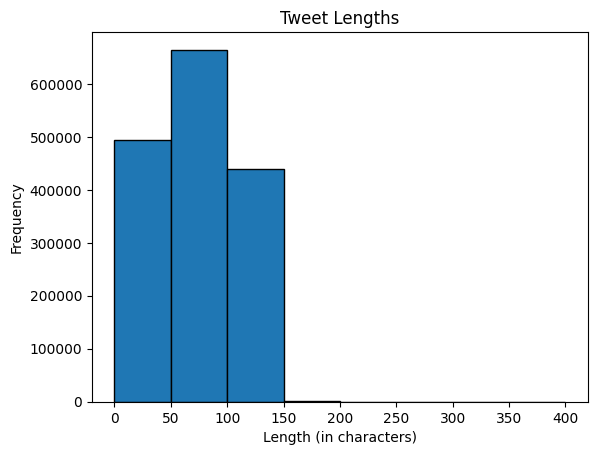

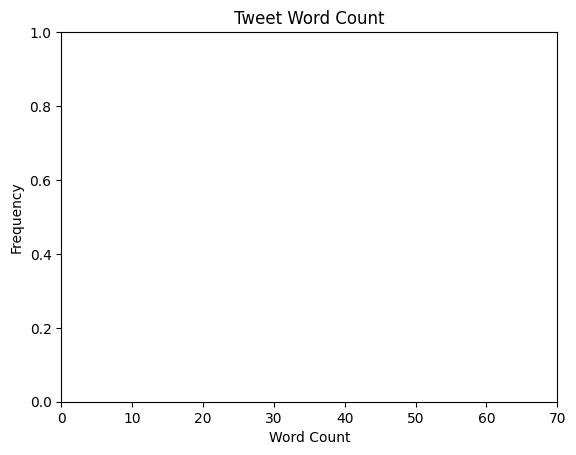

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Extracting the length (number of characters) of each tweet in Column 5 (tweet text)
tweet_lengths = df_original[5].str.len()

# Creating bin edges for the histogram with a bin width of 50
bin_edges_lengths = np.arange(0, tweet_lengths.max() + 50, 50)  # Bin width of 50

# Plotting a histogram of tweet lengths (in characters)
plt.hist(tweet_lengths, bins=bin_edges_lengths, edgecolor='black')
plt.xticks(bin_edges_lengths)  # Setting x-axis ticks to match bin edges
plt.title('Tweet Lengths')  # Adding a title
plt.xlabel('Length (in characters)')  # Labeling the x-axis
plt.ylabel('Frequency')  # Labeling the y-axis
plt.show()  # Display the plot

# Extracting the word count (number of words) for each tweet in Column 5
tweet_word_counts = df_original[5].str.split().str.len()

# Creating bin edges for the histogram with a bin width of 5
bin_edges_words = np.arange(0, tweet_word_counts.max() + 10, 10)  # Bin width of 5

# Plotting a histogram to visualize the distribution of word counts in tweets
plt.xticks(bin_edges_words)  # Setting x-axis ticks to match bin edges
plt.title('Tweet Word Count')  # Adding a title
plt.xlabel('Word Count')  # Labeling the x-axis
plt.ylabel('Frequency')  # Labeling the y-axis
plt.show()  # Display the plot


Now, we analyze the distribution of tweet lengths (number of characters) and word counts.

**Observations**:
- Most tweets in the dataset have lengths between **50 and 150 characters**
- There are no tweets exceeding the 280-character limit, as expected.
- The majority of tweets contain **10 to 20 words**.

### Note:
- I am uncertain whether this distribution of tweet lengths and word counts is ideal for NLP model training. I am **guessing** that it is.


# 3. Clean and preprocess the text

## 3.1 Preparing Relevant Columns, Sampling, and Regularizing

In [7]:
# Select only the relevant columns from the original dataset
# - Column 0: Sentiment polarity (renamed to 'polarity')
# - Column 5: Tweet text (renamed to 'tweet')
df_relevant = df_original[[0,5]].rename(columns={0: 'polarity', 5: 'tweet'})

- Training on the full dataset (1.6 million rows) would be computationally expensive.
- To speed up training, we randomly sample **20,000 rows** from the dataset.
- A `random_state` of 42 ensures the results are reproducible.

In [8]:
# Sampling a smaller dataset
# - Randomly sample 20,000 rows from the dataset
# - A fixed random_state ensures reproducibility
df_sampled = df_relevant.sample(n=20000, random_state=42)

Normalize these values to the range `[0, 1]`, as this normalization helps interpret the values as probabilities

In [9]:
# Regularizing the polarity values to the range [0, 1]
# - Original polarity values are 0 (negative) and 4 (positive)
# - Divide by 4 to scale 0 → 0 and 4 → 1
df_sampled['polarity'] = df_sampled['polarity'] / 4

## 3.2 Function to clean strings

This step involves defining and applying a cleaning function to preprocess the raw tweet text.

In [10]:
import re

# Defining a function to clean the text
def clean_text(text):
    """
    Cleans the input text by performing the following operations:
    1. Removes occurrences of "nan", mentions (@username), punctuation, URLs, 
       and any non-alphanumeric characters.
    2. Replaces all these removed components with a single space.
    3. Removes leading and trailing whitespace from the cleaned text.
    4. Converts the cleaned text to lowercase.
    
    Args:
    - text (str): The raw tweet text to be cleaned.
    
    Returns:
    - str: The cleaned text.
    """
    # Remove unwanted components using regex, then split to ensure proper spacing
    text = ' '.join(re.sub(r"(nan)|(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", text).split())
    # Strip leading/trailing spaces and convert text to lowercase
    return text.strip().lower()

# Applying the clean_text function to the 'tweet' column in the sampled dataset
# - Each row of the 'tweet' column is processed using the clean_text function
df_sampled['tweet'] = df_sampled['tweet'].apply(clean_text)

# Displaying the first 5 rows of the cleaned dataset to verify the cleaning process
df_sampled.head()

,polarity,tweet
541200,0.0,ahhh i hope your ok
750,0.0,cool i have no tweet apps for my razr 2
766711,0.0,i know just family drama its lame hey next tim...
285055,0.0,school email won t open and i have geography s...
705995,0.0,upper airways problem


## 3.3 Train test split

Now, split the data into train and test datasets (80-20 split)

In [11]:
# importing library
from sklearn.model_selection import train_test_split

In [12]:
# Extracting features (tweet text) and labels (polarity) from the sampled dataset
X = df_sampled['tweet']  # Features: the cleaned tweet text
y = df_sampled['polarity']  # Labels: normalized polarity values

# Splitting the data into training and testing sets
# - test_size=0.2: 20% of the data is reserved for testing
# - random_state=42: Ensures reproducibility of the split
# - stratify=y: Ensures the same distribution of polarity values in both training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Printing the shapes of the resulting datasets for verification
print(f'X_train dimension: {X_train.shape}; y_train dimension: {y_train.shape}')
print(f'X_test dimension: {X_test.shape}; y_train dimension: {y_test.shape}')

X_train dimension: (16000,); y_train dimension: (16000,)
X_test dimension: (4000,); y_train dimension: (4000,)


For the last step, we will create a function that performs tokenization and lemmatization on the tweets. This function will be implemented into our models later on.

In [13]:
import spacy # SpaCy is used for advanced natural language processing
from spacy.lang.en import English
from spacy.lang.en.stop_words import STOP_WORDS

In [14]:
# Loading the small English language model in SpaCy
# - "en_core_web_sm" is a lightweight model suitable for small datasets
nlp = spacy.load("en_core_web_sm")

# Accessing the predefined set of stop words from SpaCy
stop_words = spacy.lang.en.stop_words.STOP_WORDS

# Defining a function to tokenize and lemmatize a given sentence
def spacy_tokenizer(sentence):
    """
    Tokenizes and lemmatizes the input sentence using SpaCy.
    The function performs the following:
    1. Splits the sentence into individual tokens/words.
    2. Removes stop words (commonly used words with little meaning, e.g., "the", "and").
    3. Converts words into their base forms (lemmas) to standardize variations.

    Args:
    - sentence (str): The input sentence to process.

    Returns:
    - List[str]: A list of lemmatized words excluding stop words.
    """
    # Tokenize the sentence into individual words using the SpaCy pipeline
    mytokens = nlp(sentence)

    # Remove stop words and retain only the lemmatized forms of the tokens
    mytokens = [word.lemma_ for word in mytokens if word.text.lower() not in stop_words]
    
    # Return the cleaned list of lemmatized tokens
    return mytokens

# 4. Build the model

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.svm import SVR
from time import time

In [16]:
# Defining a wrapper function for the text cleaning step
def text_cleaner(x):
    """
    Cleans a list of text inputs using the clean_text function.
    Specifically for use in the SVR pipeline's preprocessing step.

    Args:
    - x (list of str): List of raw text inputs.

    Returns:
    - list of str: List of cleaned text inputs.
    """
    return [clean_text(t) for t in x]  # Applies clean_text function to each input in the list

In [17]:
# Timing the code execution
t0 = time()

# Using FunctionTransformer to apply the clean_text function within the pipeline
cleaner = FunctionTransformer(text_cleaner)

# Configuring the TF-IDF Vectorizer
# - tokenizer=spacy_tokenizer: Uses the custom tokenizer for tokenization and lemmatization
# - ngram_range=(1,1): Considers unigrams (single words) only
# - token_pattern=None: Disables the default regex-based tokenization to allow `spacy_tokenizer` to handle tokenization.
tfidf_vector = TfidfVectorizer(tokenizer = spacy_tokenizer, ngram_range = (1,1), token_pattern = None)

# Initializing the Support Vector Regressor (SVR)
regressor = SVR()

# Creating the pipeline
# - Combines the cleaner, vectorizer, and regressor into a single pipeline
pipeline = Pipeline ([("cleaner", cleaner),
                 ("vectorizer", tfidf_vector),
                 ("regressor", regressor)])

# Fitting the pipeline to the training data
pipeline.fit(X_train, y_train)

# Displaying code execution time
print(f"This took {time() - t0:.1f} seconds")

This took 242.3 seconds


Now let's see how good is the model:

In [18]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Using the pipeline to predict sentiment polarity for the test dataset
y_pred = pipeline.predict(X_test)

# Calculating evaluation metrics:
# - MSE (Mean Squared Error): Indicates how close the predictions are to the actual values (lower is better).
# - MAE (Mean Absolute Error): Represents the average magnitude of errors in the predictions (lower is better).
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

# Printing the calculated metrics
print(f"MSE: {mse}, MAE: {mae}")


MSE: 0.17951278796961445, MAE: 0.3663678425827072


# 5. Save the model

In this following code, `cloudpickle` was chosen because it can serialize certain objects that cannot be serialized by `pickle` or `joblib` (E.g. `FunctionTransformer` that apply custom functions to transform data).

In [19]:
import cloudpickle

# Save the model using cloudpickle
with open("svr_pipeline.pkl", "wb") as file:
    cloudpickle.dump(pipeline, file)
    
print("Model saved!")

Model saved!
